In [1]:
# Basic imports
import logging
import sys
from pathlib import Path

# Science imports
import numpy as np
import pandas as pd
import scipy as sp

from specutils import Spectrum1D
from specutils.fitting.continuum import fit_continuum
from astropy.modeling.models import BlackBody
import astropy.units as u
from astropy.table import Table


# Matplotlib stuff
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize
import cmasher as cmr  # for colors

In [2]:
from zhunter import DIRS

# Astropalmerio stuff
from astropalmerio.io.fits import read_fits_2D_spectrum, read_fits_1D_spectrum

from astropalmerio.spectra.utils import *
from astropalmerio.spectra.conversions import *
from astropalmerio.spectra.reduction import extract_1D_from_2D
from astropalmerio.spectra.visualization import fig_resid, show_flux_integration_bounds

import astropalmerio.mc as mc
from astropalmerio.mc.utils import *

from astropalmerio.galaxies.extinction import correct_line_for_extinction
from astropalmerio.galaxies.properties import Av_from_Balmer_decrement, star_formation_rate

from zhunter.io import ascii_read

In [3]:
ROOT_DIR = Path('/Users/palmerio/Code_projects/zHunter/src/zhunter/data/')
plt.style.use('paper')
plt.style.use('kraken')


In [4]:
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [5]:
savefiles = False

## Atmospheric transmission in the NIR
Data is from https://www.gemini.edu/observing/telescopes-and-sites/sites#SkyBackground

In the worse case scenario for Mauna Kea (airmass of 2, water vapor column of 5mm)

In [6]:
# Read data
fname_trans_nir = ROOT_DIR/'tellurics/mk_trans_zm_50_20.dat.gz'   

data_trans_nir = pd.read_csv(fname_trans_nir, sep='\s+', comment='#')
data_trans_nir


,wave(um),flux_norm
0,0.90000,0.993189
1,0.90002,0.992915
2,0.90004,0.993062
3,0.90006,0.991189
4,0.90008,0.988767
...,...,...
234995,5.59990,0.000225
234996,5.59992,0.000215
234997,5.59994,0.000204
234998,5.59996,0.000193


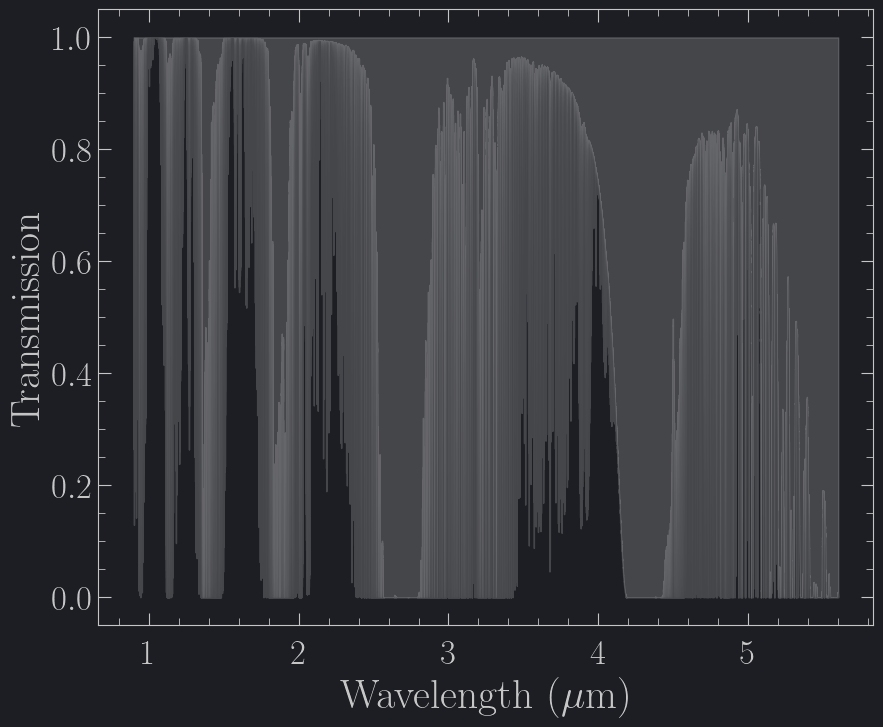

In [7]:
fig, ax = plt.subplots()

ax.fill_between(
    data_trans_nir['wave(um)'], 
    1,
    data_trans_nir['flux_norm'],
    alpha=0.2,
    color='C12'
)
ax.set_ylabel('Transmission')
ax.set_xlabel('Wavelength ($\mu$m)')
plt.show()

## Atmospheric transmission in the optical
Data is from iSpec: https://github.com/marblestation/iSpec

High-resolution synthetic telluric spectrum

In [9]:
fname_trans_opt = ROOT_DIR/'tellurics/synth_tellurics_350_1100nm.csv.gz'   

data_trans_opt = pd.read_csv(fname_trans_opt)
data_trans_opt

,awav(AA),flux_norm
0,3500.11,1.0
1,3500.12,1.0
2,3500.13,1.0
3,3500.14,1.0
4,3500.15,1.0
...,...,...
749984,10999.95,1.0
749985,10999.96,1.0
749986,10999.97,1.0
749987,10999.98,1.0


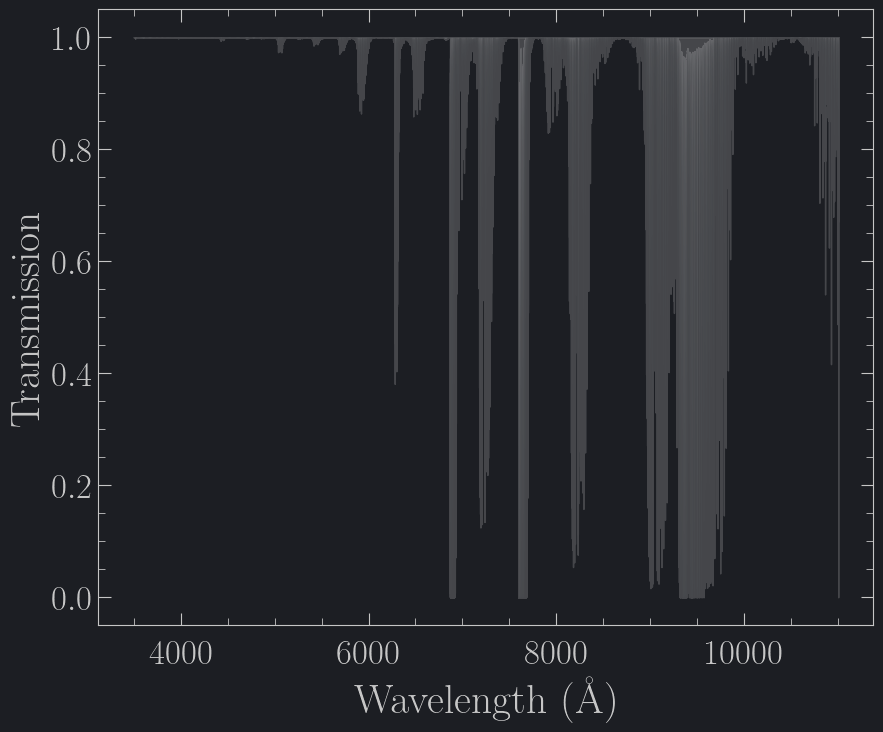

In [10]:
fig, ax = plt.subplots()

ax.fill_between(
    data_trans_opt['awav(AA)'], 
    1,
    data_trans_opt['flux_norm'],
    alpha=0.2,
    color='C12'
)
ax.set_ylabel('Transmission')
ax.set_xlabel('Wavelength (Å)')
plt.show()

## Combining Optical and NIR transmission spectra

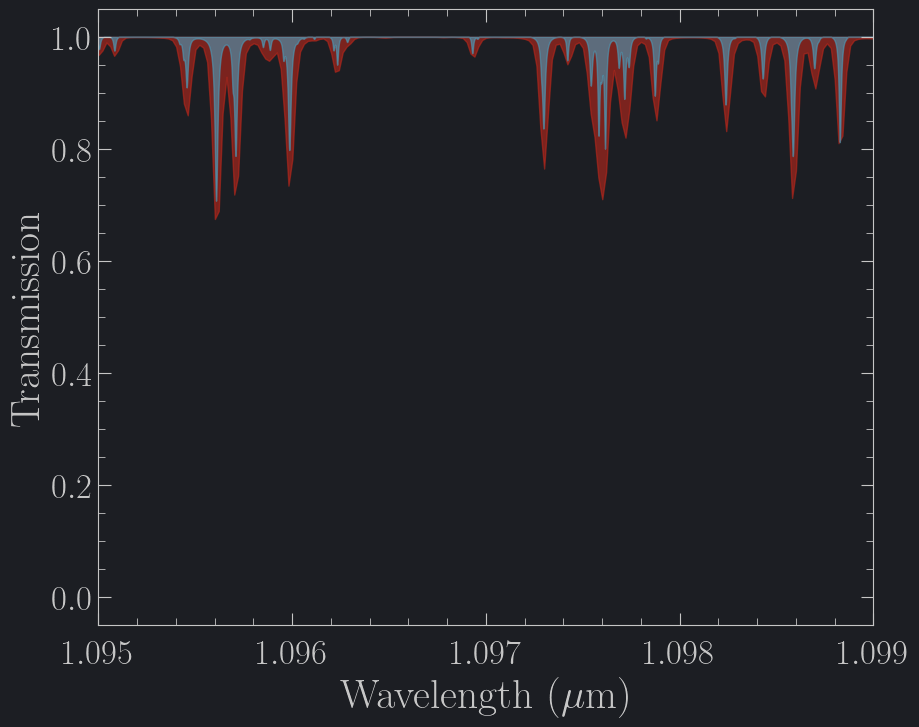

In [11]:
# Make sure both spectra are in the same reference frame (air vs vacuum) and same units
fig, ax = plt.subplots()

data_trans_nir['awav(um)'] = vac_to_air(data_trans_nir['wave(um)'].to_numpy()*u.um).value+0.00002 #add arbitrary shift to make them match better
data_trans_opt['awav(um)'] = data_trans_opt['awav(AA)']*1e-4

ax.fill_between(
    data_trans_nir['awav(um)'],
    1,
    data_trans_nir['flux_norm'],
    alpha=0.6,
    color='C4'
)


ax.fill_between(
    data_trans_opt['awav(um)'],
    1,
    data_trans_opt['flux_norm'],
    alpha=0.6,
    color='C0'
)

ax.set_xlim(1.095, 1.099)
# ax.set_xlim(0.90, 0.905)
ax.set_ylabel('Transmission')
ax.set_xlabel('Wavelength ($\mu$m)')
plt.show()

In [12]:
wave_max_opt = np.max(data_trans_opt['awav(um)'])
ind_max_opt = data_trans_nir['awav(um)'].searchsorted(wave_max_opt)

awav_nir = data_trans_nir['awav(um)'].to_numpy()[ind_max_opt:]
flux_nir = data_trans_nir['flux_norm'].to_numpy()[ind_max_opt:]

awav_opt = data_trans_opt['awav(um)'].to_numpy()
flux_opt = data_trans_opt['flux_norm'].to_numpy()


awav_combined = np.concatenate((awav_opt, awav_nir))
flux_combined = np.concatenate((flux_opt, flux_nir))
tab_combined = Table({
    'awav(um)':awav_combined*u.um,
    'flux_norm':flux_combined,
})


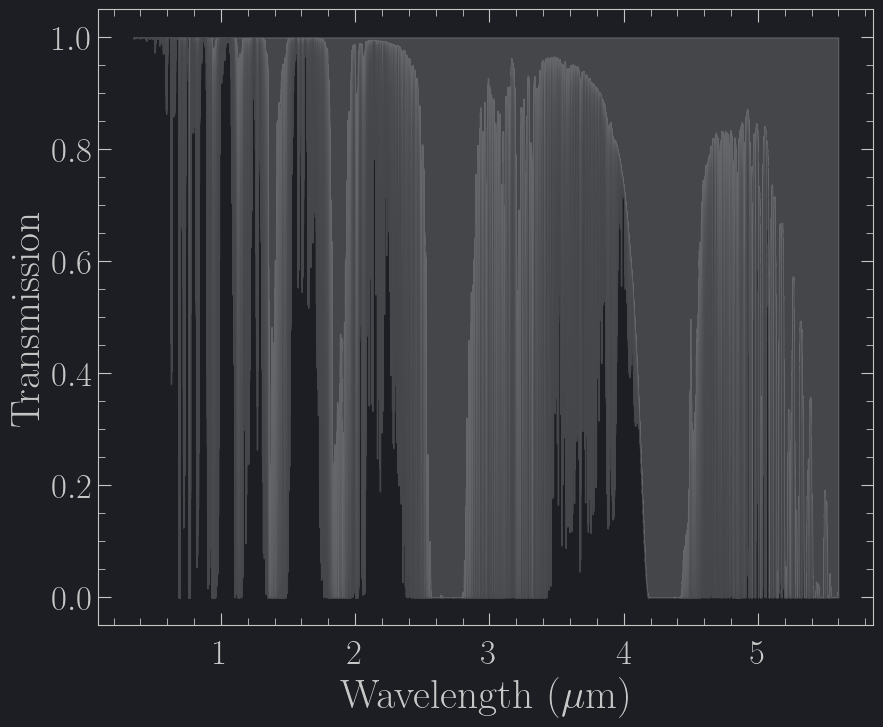

In [15]:
fig, ax = plt.subplots()

ax.fill_between(
    tab_combined['awav(um)'], 
    1,
    tab_combined['flux_norm'],
    alpha=0.2,
    color='C12'
)
ax.set_ylabel('Transmission')
ax.set_xlabel(r'Wavelength ($\mu$m)')
plt.show()

In [16]:
if savefiles:
    tab_combined.write(ROOT_DIR/'tellurics/sky_transimission_optical_to_nir.ecsv')

## Sky background emission in the NIR
Data is from https://www.gemini.edu/observing/telescopes-and-sites/sites#SkyBackground

Worse case scenario for Mauna Kea (airmass 2, water vapor column 5mm).
Doesn't include emission from the Moon

In [17]:
# Convert to ECSV
# fname_bkg = ROOT_DIR/'sky_background/mk_skybg_zm_50_20_ph.dat'
# data = ascii_read(fname_bkg)
# data['awav(nm)'].unit = u.nm
# data['sky_bkg(ph/sec/arcsec^2/nm/m^2)'].unit = u.Unit('ph/s/arcsec^2/nm/m^2')

# data.write(ROOT_DIR/'sky_background/mk_skybkg_zm_50_20_ph.ecsv')


In [20]:
fname_bkg = ROOT_DIR/'sky_background/mk_skybkg_nir_50_20_ph.ecsv.gz'
data_bkg_nir = ascii_read(fname_bkg)
data_bkg_nir

awav,sky_bkg
nm,ph / (arcsec2 m2 nm s)
float64,float64
900.0,1.308428
900.02,1.332177
900.04,1.354324
900.06,1.371824
900.08,1.386476
900.1,1.398439
900.1199,1.395535
900.14,1.394949


In [21]:
sky_bkg_nir = Spectrum1D(
    spectral_axis = Quantity(data_bkg_nir['awav']),
    flux = Quantity(data_bkg_nir['sky_bkg']),
)

### Fit the continuum of the sky background
This allows us to then to normalise it and remove contribution from telluric absorption (because the point is to get the sky emission here)

In [53]:
# Define regions in the spectrum where the continuum is clean
# This takes a long time to compute...
continuum_windows = [
                        (900.74*u.nm, 900.79*u.nm),
                        (904.7*u.nm, 904.9*u.nm),
                        (905.7*u.nm, 905.9*u.nm),
                        (912.4*u.nm, 912.5*u.nm),
                        (967.92*u.nm, 968.1*u.nm),
                        (977.27*u.nm, 977.4*u.nm),
                        (993.98*u.nm, 994.24*u.nm),
                        (1011.33*u.nm, 1011.74*u.nm),
                        (1049.16*u.nm, 1049.75*u.nm),
                        (1175.9*u.nm, 1176.56*u.nm),
                        (1253.2*u.nm, 1253.9*u.nm),
                        (1317.43*u.nm, 1317.68*u.nm),
                        (1520.89*u.nm, 1521.38*u.nm),
                        (1698.4*u.nm, 1699.03*u.nm),
                        (1821.5*u.nm, 1822.59*u.nm),
                    ]

cont = fit_continuum(sky_bkg_nir,
                    window=continuum_windows)

2023-03-07 15:44:40,268 WARNING [astropy] Model is linear in parameters; consider using linear fitting methods.


In [62]:
# Define some parameters
bb = BlackBody(temperature=273*u.K)
rel_bb_intensity = 1.9e16

wave = sky_bkg_nir.spectral_axis
flux = sky_bkg_nir.flux

continuum = np.where(
    wave.value < continuum_windows[-1][-1].value,
    cont(wave).value,
    rel_bb_intensity*bb(wave).value,
)
   
# Normalize flux by continuum and set all values below 1 equal to 1
# Because we only care about emission here
flux_norm = flux/continuum
flux_norm = np.where(
    flux_norm.value <= 1,
    1,
    flux_norm.value
)


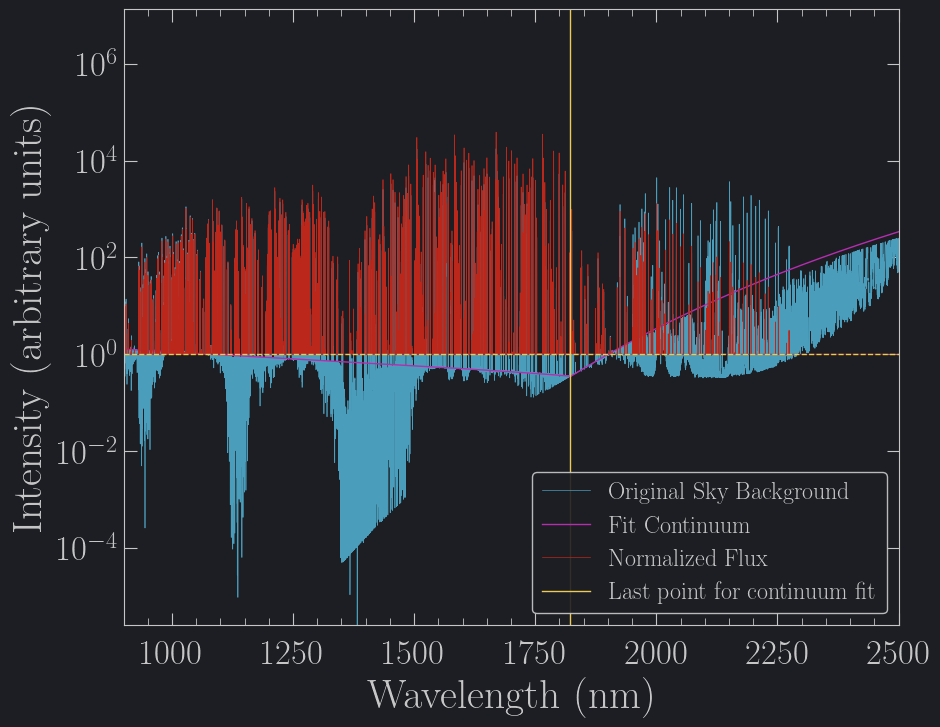

In [63]:
fig, ax = plt.subplots()


ax.plot(wave, flux, lw=0.5, color='C0', label='Original Sky Background')
ax.plot(wave, continuum, color='C2', lw=1, label='Fit Continuum')
ax.plot(wave, flux_norm, color='C4', lw=0.5, label='Normalized Flux')
ax.axhline(1, lw=1, ls='--')
ax.axvline(continuum_windows[-1][-1].value, lw=1, label='Last point for continuum fit')
ax.set_xlim(900, 2500)

ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Intensity (arbitrary units)')
ax.set_xlabel('Wavelength (nm)')

plt.show()

In [ ]:
## Restrict only to the part of the spectrum that is observed by X-Shooter
awav = vac_to_air(wave) + 0.1 * u.AA
awav_min = 900 * u.nm
awav_max = 2300 * u.nm
imin = awav.searchsorted(awav_min)
imax = awav.searchsorted(awav_max)
sky_bkg_nir_norm = Table({
    'awav(um)':awav[imin:imax].to(u.um),
    'flux_norm':flux_norm[imin:imax],  # relative intensity
})

In [22]:
if savefiles:
    sky_bkg_nir_norm.write(f"/Users/palmerio/Code_projects/zHunter/src/zhunter/data/sky_background/sky_bkg_norm_nir.ecsv")


In [60]:
# Convert to ecsv
# fname_bkg_opt = ROOT_DIR/'sky_background/mk_skybkg_opt_50_10.dat'

# data_bkg_opt = ascii_read(fname_bkg_opt)
# data_bkg_opt['awav'].unit = u.Unit('nm')
# data_bkg_opt['flux'].unit = u.Unit('ph/s/nm/arcsec^2/m^2')
# data_bkg_opt.write(ROOT_DIR/'sky_background/mk_skybkg_opt_50_10.ecsv')

In [24]:
fname_bkg_opt = ROOT_DIR/'sky_background/mk_skybkg_opt_50_10.ecsv.gz'
data_bkg_opt = ascii_read(fname_bkg_opt)
data_bkg_opt

awav,flux
nm,ph / (arcsec2 m2 nm s)
float64,float64
320.0,0.0
349.99,0.0
350.17,0.6506
350.43,0.6504
350.7,0.6501
350.96,0.6499
351.23,0.6496
351.49,0.6494


In [25]:
sky_bkg_opt = Spectrum1D(
    spectral_axis = Quantity(data_bkg_opt['awav']),
    flux = Quantity(data_bkg_opt['flux']),
)

In [88]:
# Define regions in the spectrum where the continuum is clean
# This takes a long time to compute...
continuum_windows = [
                        (500.0*u.nm, 510.0*u.nm),
                        (539.86932*u.nm, 543.10806*u.nm),
                        (575.40289*u.nm, 580.12219*u.nm),
                        (608.44157*u.nm, 609.41341*u.nm),
                        (643.70647*u.nm, 644.35437*u.nm),
                        (659.19116*u.nm, 660.61653*u.nm),
                        (667.36759*u.nm, 669.63522*u.nm),
                        (701.14234*u.nm, 703.34518*u.nm),
                        (718.24676*u.nm, 722.84681*u.nm),
                        (767.38309*u.nm, 768.67888*u.nm),
                        (786.37936*u.nm, 787.99910*u.nm),
                        (832.59369*u.nm, 833.56553*u.nm),
                        (870.65264*u.nm, 873.73340*u.nm),
                        (906.65902*u.nm, 907.62176*u.nm),
                        (913.69861*u.nm, 914.78293*u.nm),
                    ]

cont = fit_continuum(sky_bkg_opt,
                    window=continuum_windows)

In [89]:
wave = sky_bkg_opt.spectral_axis
flux = sky_bkg_opt.flux

continuum = np.where(
    wave.value < continuum_windows[-1][-1].value,
    cont(wave).value,
    3,
)
   
# Normalize flux by continuum and set all values below 1 equal to 1
# Because we only care about emission here
flux_norm = flux/continuum
flux_norm = np.where(
    flux_norm.value <= 1,
    1,
    flux_norm.value
)


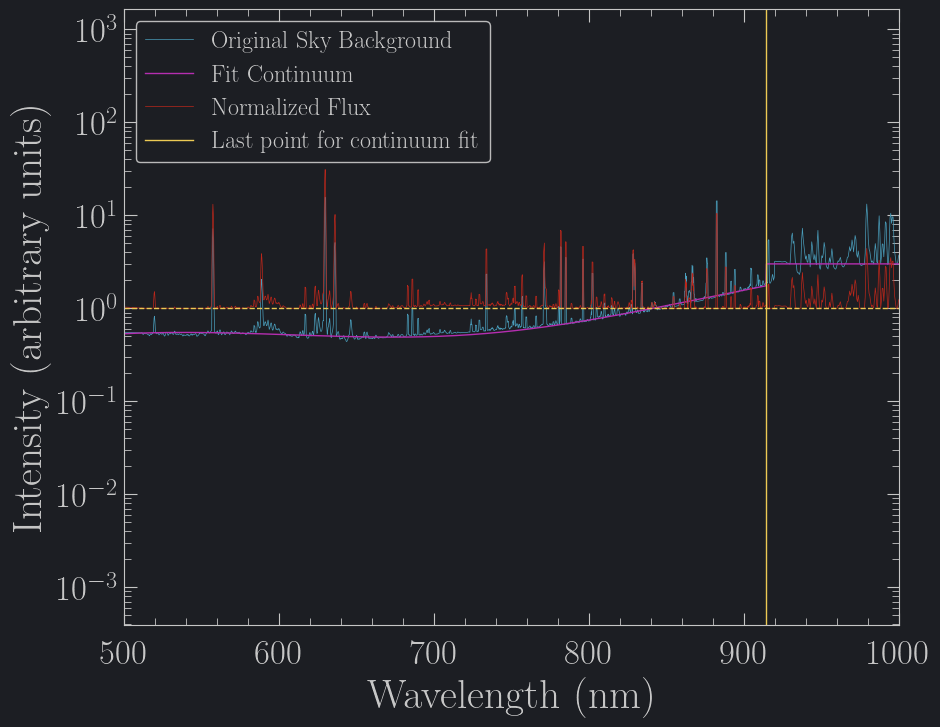

In [91]:
fig, ax = plt.subplots()


ax.plot(wave, flux, lw=0.5, color='C0', label='Original Sky Background')
ax.plot(wave, continuum, color='C2', lw=1, label='Fit Continuum')
ax.plot(wave, flux_norm, color='C4', lw=0.5, label='Normalized Flux')
ax.axhline(1, lw=1, ls='--')
ax.axvline(continuum_windows[-1][-1].value, lw=1, label='Last point for continuum fit')
ax.set_xlim(500, 1000)

ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Intensity (arbitrary units)')
ax.set_xlabel('Wavelength (nm)')

plt.show()

In [ ]:
## Restrict only to the part of the spectrum that is observed by X-Shooter
awav = vac_to_air(wave) + 0.1 * u.AA
awav_min = 500 * u.nm
awav_max = 900 * u.nm
imin = awav.searchsorted(awav_min)
imax = awav.searchsorted(awav_max)
sky_bkg_opt_norm = Table({
    'awav(um)':awav[imin:imax].to(u.um),
    'flux_norm':flux_norm[imin:imax],  # relative intensity
})

In [100]:
if savefiles:
    sky_bkg_opt_norm.write(f"/Users/palmerio/Code_projects/zHunter/src/zhunter/data/sky_background/sky_bkg_norm_opt.ecsv")


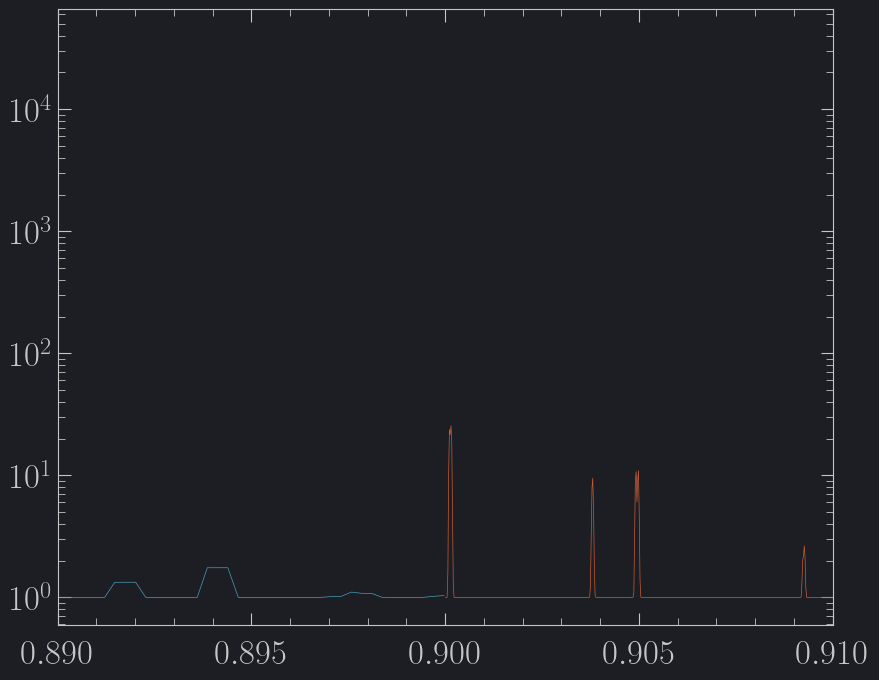

In [101]:
fig, ax = plt.subplots()

ax.plot(sky_bkg_nir_norm['awav(um)'], sky_bkg_nir_norm['flux_norm'], lw=0.5, color='C1', alpha=1)
ax.plot(sky_bkg_opt_norm['awav(um)'], sky_bkg_opt_norm['flux_norm'], lw=0.5, color='C0', alpha=1)

ax.set_xlim(.89, 0.91)
ax.set_yscale('log')
plt.show()

In [103]:
wave_max_opt = np.max(sky_bkg_opt_norm['awav(um)'])
ind_max_opt = sky_bkg_nir_norm['awav(um)'].searchsorted(wave_max_opt)

awav_nir = np.array(sky_bkg_nir_norm['awav(um)'])[ind_max_opt:]
flux_nir = np.array(sky_bkg_nir_norm['flux_norm'])[ind_max_opt:]

awav_opt = np.array(sky_bkg_opt_norm['awav(um)'])
flux_opt = np.array(sky_bkg_opt_norm['flux_norm'])


awav_combined = np.concatenate((awav_opt, awav_nir))
flux_combined = np.concatenate((flux_opt, flux_nir))
tab_combined = Table({
    'awav(um)':awav_combined*u.um,
    'flux_norm':flux_combined,
})


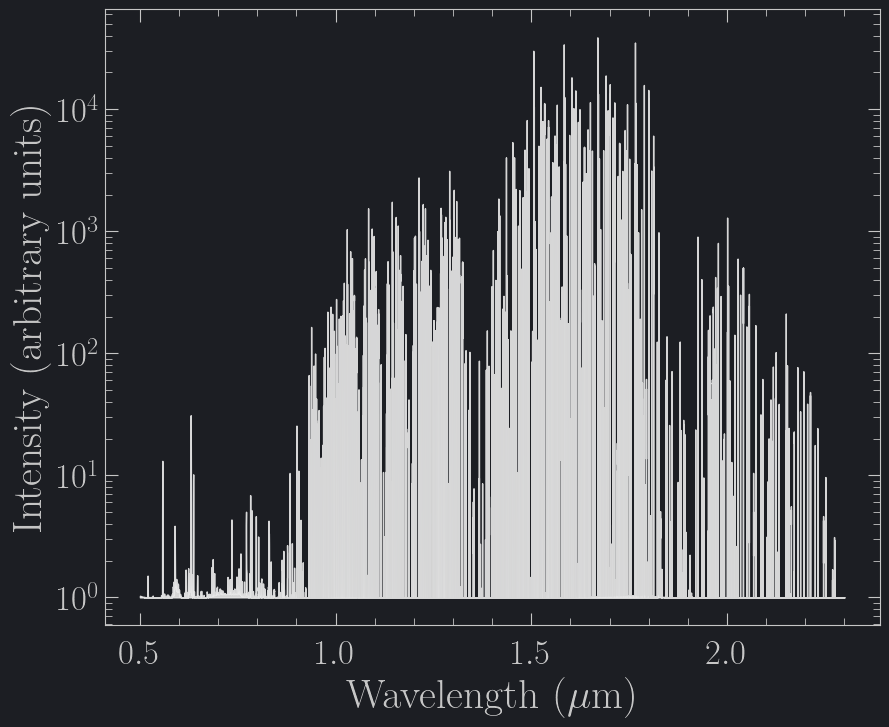

In [104]:
fig, ax = plt.subplots()

ax.fill_between(
    tab_combined['awav(um)'], 
    1,
    tab_combined['flux_norm'],
    alpha=0.9,
    color='C12'
)
ax.set_yscale('log')
ax.set_ylabel('Intensity (arbitrary units)')
ax.set_xlabel(r'Wavelength ($\mu$m)')
plt.show()

In [107]:
if savefiles:
    tab_combined.write(ROOT_DIR/'sky_background/sky_background_norm_opt_to_nir.ecsv')
